In [1]:
import torch
import numpy as np
import random

# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# If you are using CUDA, set the seed for all GPUs
torch.cuda.manual_seed_all(seed)

In [2]:
##################################Inter the Parameters###############################################################


# Hypervector Dimension
hv_d = 1000

# Number of Epochs
n_epochs = 4

sigma_basis = 0.2

# Percentage
drop_rate = 61

n_generation = 100

In [3]:
import sklearn
import time
from scipy import stats
import torchhd
import torch
import sys
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math
import numpy as np
import copy
import random
import joblib
from tqdm import tqdm
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from torch import nn
from torch.optim import Adam
from tqdm import tqdm_notebook
from tabulate import tabulate
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import scipy.misc
from PIL import Image
import skimage
from skimage import data
from skimage.color import rgb2gray
import torch.nn.functional as F
import torch.optim as optim
import scipy.misc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
#################################  Dataset  #####################################################    

highspeed_data = np.squeeze(np.load('highspeed_data.npy'))

highspeed_label = np.squeeze(np.load('highspeed_label.npy'))

In [5]:
def get_data(highspeed_data,highspeed_label):
    traindata, testdata, trainlabels, testlabels = train_test_split(
        highspeed_data, highspeed_label,test_size=0.3, random_state=42,stratify=highspeed_label)



    shuf_train = np.random.permutation(len(traindata))
    traindata = traindata[shuf_train]
    trainlabels = trainlabels[shuf_train]

    shuf_test = np.random.permutation(len(testdata))
    testdata = testdata[shuf_test]
    testlabels = testlabels[shuf_test]


    traindata = torch.from_numpy(traindata).cuda()
    testdata = torch.from_numpy(testdata).cuda()

    trainlabels = torch.from_numpy(trainlabels).cuda()
    testlabels = torch.from_numpy(testlabels).cuda()
    
    return traindata,testdata,trainlabels,testlabels 

In [6]:
acc_low2 = []
acc_high2 = []

for i_gen in range(n_generation):

    traindata,testdata,trainlabels,testlabels = get_data(highspeed_data,highspeed_label)
    nClasses = len(torch.unique(trainlabels))
    nFeatures = traindata.shape[1]
    len_train = len(traindata)


    basis = torch.zeros((nFeatures,hv_d), dtype=torch.float64).cuda()
    for i_bas in range(hv_d):
        basis[:,i_bas] = torch.normal(mean=0, std=sigma_basis, size=(nFeatures,)).cuda()

    bias_vect = torch.rand(hv_d, device='cuda') * 2 * torch.pi

    trainencoded  = torch.cos(torch.matmul(traindata, basis)+bias_vect).cuda()
    testencoded  = torch.cos(torch.matmul(testdata, basis)+bias_vect).cuda()

    class_hvs = torch.zeros((nClasses,hv_d), dtype=torch.float64).cuda()
    for i_sub in range(len_train):
        class_hvs[trainlabels[i_sub]] += trainencoded[i_sub]


    for i_epoch in range(n_epochs):
        len_train_sh = list(range(len_train))
        random.shuffle(len_train_sh)
        for i_sub in len_train_sh:
            guess = torch.matmul(class_hvs,trainencoded[i_sub]).argmax()
            if guess!= trainlabels[i_sub]:
                class_hvs[trainlabels[i_sub]] = class_hvs[trainlabels[i_sub]] + trainencoded[i_sub]
                class_hvs[guess] = class_hvs[guess] - trainencoded[i_sub]        


    queries_encoded = copy.deepcopy(testencoded)

    normed_queries = copy.deepcopy(queries_encoded)
    variances_q = torch.var(normed_queries, axis = 0).cuda()
    orders = torch.argsort(variances_q).cuda()


    queries_low = copy.deepcopy(queries_encoded)
    acc_low = []
    predict = torch.matmul(queries_low,class_hvs.T).argmax(axis=1)
    test_acc = torch.sum(predict == testlabels).item() / len(testlabels)
    acc_low.append(test_acc)
    for dr in range(5,drop_rate,5):
        drop_i = dr/100
        amountDrop = int(drop_i * hv_d)
        lo_idx = orders[:amountDrop]
        for i_indx in lo_idx:
            queries_low[:,i_indx] =  torch.zeros((len(testencoded),), dtype=torch.float64).cuda()

        predict = torch.matmul(queries_low,class_hvs.T).argmax(axis=1)
        test_acc = torch.sum(predict == testlabels).item() / len(testlabels)
        acc_low.append(test_acc)


    queries_high = copy.deepcopy(queries_encoded)
    acc_high = []
    predict = torch.matmul(queries_high,class_hvs.T).argmax(axis=1)
    test_acc = torch.sum(predict == testlabels).item() / len(testlabels)
    acc_high.append(test_acc)
    for dr in range(5,drop_rate,5):
        drop_i = dr/100
        amountDrop = int(drop_i * hv_d)
        hi_idx = orders[-amountDrop:]
        for i_indx in hi_idx:
            queries_high[:,i_indx] =  torch.zeros((len(testencoded),), dtype=torch.float64).cuda()

        predict = torch.matmul(queries_high,class_hvs.T).argmax(axis=1)
        test_acc = torch.sum(predict == testlabels).item() / len(testlabels)

        acc_high.append(test_acc)

        
    acc_low2.append(np.asarray(acc_low))
    acc_high2.append(np.asarray(acc_high))

In [7]:
accur_low = np.asarray(acc_low2)
accur_high = np.asarray(acc_high2)

In [8]:
accuracy_low = np.mean(accur_low,axis=0)
accuracy_high = np.mean(accur_high,axis=0)

In [9]:
class DecoderNetwork(nn.Module):
    def __init__(self, hidden_size=512):
        super(DecoderNetwork, self).__init__()
        
        self.fc1 = nn.Linear(hv_d, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, nFeatures)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [10]:
def compute_nmse(predictions, targets):
    mse = ((predictions - targets) ** 2).mean().item()
    var_y = targets.var().item()
    nmse = mse / var_y
    return nmse

In [11]:
nmse_low2 = []
nmse_high2 = []

hsc_data=np.squeeze(np.load('NIST_HIGHSPEED_DATA.npy'))
hsc_data = hsc_data.reshape((256,256,3,hsc_data.shape[1])) 

b_wire=[]
for i in range (hsc_data.shape[3]):
    a_wire = rgb2gray(hsc_data[:,:,:,i])
    a_wire = skimage.measure.block_reduce(a_wire, (8,8), np.max)
    b_wire.append(a_wire.reshape((a_wire.shape[0]*a_wire.shape[1],)))


highspeed_data = np.asarray(b_wire)
for i_gen in range(n_generation):

    traindata,testdata,trainlabels,testlabels = get_data(highspeed_data,highspeed_label)
    nClasses = len(torch.unique(trainlabels))
    nFeatures = traindata.shape[1]
    len_train = len(traindata)

    basis = torch.zeros((nFeatures,hv_d), dtype=torch.float64).cuda()
    for i_bas in range(hv_d):
        basis[:,i_bas] = torch.normal(mean=0, std=sigma_basis, size=(nFeatures,)).cuda()

    trainencoded  = torch.cos(torch.matmul(traindata, basis)).cuda()
    testencoded  = torch.cos(torch.matmul(testdata, basis)).cuda()

    # Create and move the model to GPU
    model = copy.deepcopy(DecoderNetwork().cuda()).double()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 10
    batch_size = 32
    for epoch in range(epochs):
        for i in range(0, len(trainencoded), batch_size):
            inputs = trainencoded[i:i+batch_size]
            labels = traindata[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


    queries_encoded = copy.deepcopy(testencoded)

    normed_queries = copy.deepcopy(queries_encoded)
    variances_q = torch.var(normed_queries, axis = 0).cuda()
    orders = torch.argsort(variances_q).cuda()


    queries_low = copy.deepcopy(queries_encoded)
    nmse_low = []
    with torch.no_grad():
        predictions = model(queries_low) 
        nmse_low.append(compute_nmse(predictions, testdata))

    for dr in range(5,drop_rate,5):
        drop_i = dr/100
        amountDrop = int(drop_i * hv_d)
        lo_idx = orders[:amountDrop]
        for i_indx in lo_idx:
            queries_low[:,i_indx] =  torch.zeros((len(testencoded),), dtype=torch.float64).cuda()

        with torch.no_grad():
            predictions = model(queries_low) 
            nmse_low.append(compute_nmse(predictions, testdata))


    queries_high = copy.deepcopy(queries_encoded)
    nmse_high = []
    with torch.no_grad():
        predictions = model(queries_high) 
        nmse_high.append(compute_nmse(predictions, testdata))
    for dr in range(5,drop_rate,5):
        drop_i = dr/100
        amountDrop = int(drop_i * hv_d)
        hi_idx = orders[-amountDrop:]
        for i_indx in hi_idx:
            queries_high[:,i_indx] =  torch.zeros((len(testencoded),), dtype=torch.float64).cuda()

        with torch.no_grad():
            predictions = model(queries_high) 
            nmse_high.append(compute_nmse(predictions, testdata))
            
    nmse_low2.append(np.asarray(nmse_low))
    nmse_high2.append(np.asarray(nmse_high))

In [12]:
er_low = np.asarray(nmse_low2)
er_high = np.asarray(nmse_high2)

In [13]:
error_low = np.mean(er_low,axis=0)
error_high = np.mean(er_high,axis=0)

In [14]:
drop_perc = np.asarray(range(0,drop_rate,5))

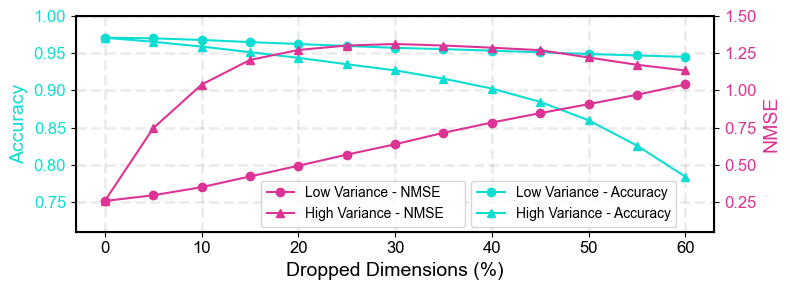

In [16]:
plt.figure
f ,ax= plt.subplots(figsize=(8,3))
ax.grid(color='gray', linestyle='--', linewidth=2, alpha = 0.15)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

plt.plot(drop_perc, accuracy_low, '-o', linewidth=1.5, label='Low Variance - Accuracy', color='#0DDDD3')
plt.plot(drop_perc, accuracy_high, '-^', linewidth=1.5, label='High Variance - Accuracy', color='#0DDDD3')
plt.ylabel('Accuracy', font='arial',fontsize=14,color='#0DDDD3')
aa_fardin=np.asarray([0.75,0.8,0.85,0.9,.95,1])
plt.yticks(aa_fardin,font='arial',fontsize=12,color='#0DDDD3')
plt.xticks([0,10,20,30,40,50,60],font='arial',fontsize=12)

plt.ylim([0.71,1])

ax2 = ax.twinx() 
ax2.plot(drop_perc, error_low, '-o', linewidth=1.5, label='Low Variance - NMSE    ', color='#DD3394')
ax2.plot(drop_perc, error_high, '-^', linewidth=1.5, label='High Variance - NMSE    ', color='#DD3394')

ax2.set_ylabel('NMSE', fontname='Arial', fontsize=14,color='#DD3394')
aa_fardin=np.asarray([0.25,0.5,0.75,1,1.25,1.5])
plt.yticks(aa_fardin,font='arial',fontsize=12,color='#DD3394')
ax2.set_ylim([0.05,1.5]) 


ax2.legend(loc='center',ncol=1, fontsize=10, prop={'family': 'Arial'},bbox_to_anchor=(0.45, 0.13))
ax.legend(loc='center',ncol=1, fontsize=10, prop={'family': 'Arial'},bbox_to_anchor=(0.78, 0.13))


ax.set_xlabel('Dropped Dimensions (%)',font='arial', fontsize=14)

plt.tight_layout()
plt.show()